
#Assignment-#02
###Stereo Depth Estimation Using SIFT. Complete each question by implementing the required functions and code cells, following the instructions provided.



### Import Libraries


In [154]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Define Camera Parameters

In [155]:
#Given the focal length and baseline
focal_length = 4152.073
baseline =  176.252

### Load Stereo Images

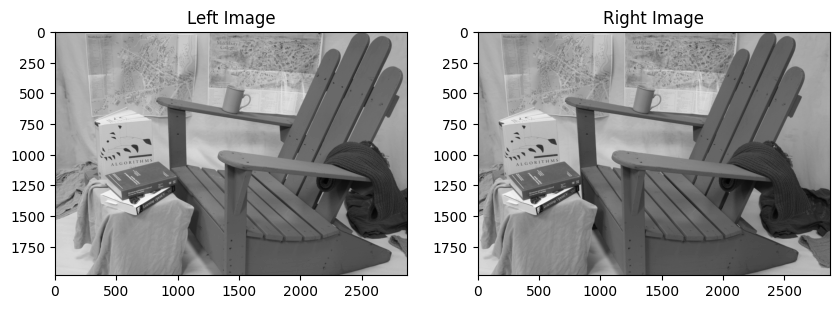

In [156]:
# Load left and right images
left_image = cv2.imread('./Images/im0.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('./Images/im1.png', cv2.IMREAD_GRAYSCALE)


if left_image is None or right_image is None:
    raise ValueError("Images not found! Make sure 'left_image.jpg' and 'right_image.jpg' are in the same directory.")

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(left_image, cmap='gray'), plt.title("Left Image")
plt.subplot(1, 2, 2), plt.imshow(right_image, cmap='gray'), plt.title("Right Image")
plt.show()

### Describe the differences you observe in the left and right images (2 Points)

## 2. Write a function to detects and matches SIFT features between two images using 
FLANN-based matcher and Lowe's ratio test.

In [157]:
# Custom DrawMatches Function Instead of CV2 Function 
def drawMatches(img1, kp1, img2, kp2, matches):

    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')
    out[:rows1,:cols1] = np.dstack([img1])
    out[:rows2,cols1:] = np.dstack([img2])
    for mat in matches:
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0, 1), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0, 1), 1)
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0, 1), 1)

    return out

def detect_and_match_features(left_image, right_image, ratio_test_threshold=0.7):
    
    sift = cv2.SIFT_create()
    keypointsLeft, descriptorsLeft = sift.detectAndCompute(left_image, None)
    keypointsRight, descriptorsRight = sift.detectAndCompute(right_image, None)
    
    
    index = dict(algorithm=1, trees=6)
    search = dict(checks=100)
    
    flann = cv2.FlannBasedMatcher(index, search)
    matches = flann.knnMatch(descriptorsLeft, descriptorsRight, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test_threshold * n.distance:
            good_matches.append(m)
            
    # Limiting number of matches to 2000
    #good_matches = sorted(good_matches, key=lambda x: x.distance)[:2000]        
    matched_image = drawMatches(left_image, keypointsLeft, right_image, keypointsRight, good_matches)

    return good_matches, keypointsLeft, keypointsRight, matched_image

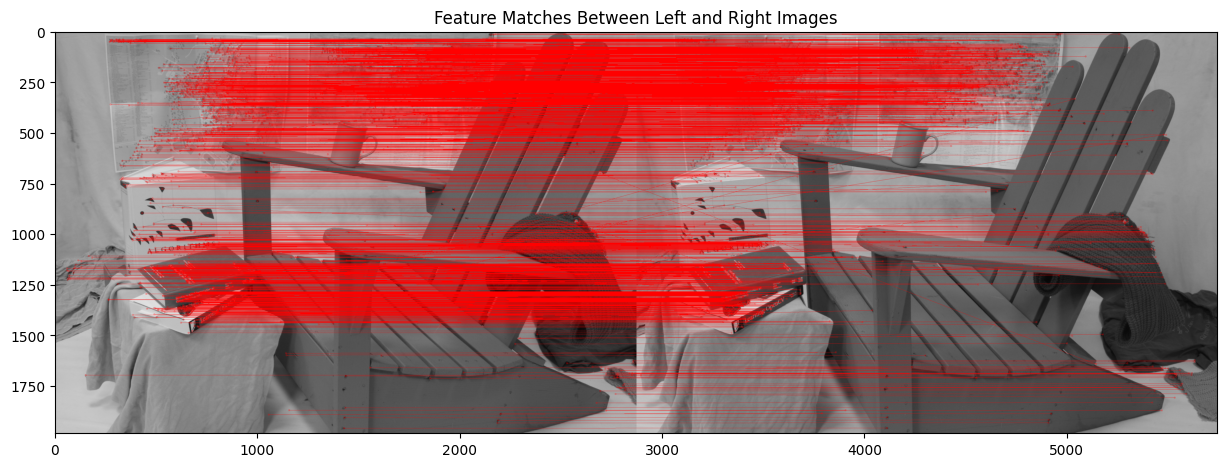

In [158]:
good_matches, keypoints_left, keypoints_right, matched_image = detect_and_match_features(left_image, right_image)
plt.figure(figsize=(15, 10))
plt.imshow(matched_image)
plt.title("Feature Matches Between Left and Right Images")
plt.show()

3. 

In [159]:
def calculate_disparity(keypoints_left, keypoints_right, good_matches, doffs=0):
    """
    Calculates the disparity between matched keypoints in left and right images.

    Parameters:
    - keypoints_left: Keypoints from the left image.
    - keypoints_right: Keypoints from the right image.
    - good_matches: List of good matches from feature matching.
    - doffs: Disparity offset (default is 0).

    Returns:
    - disparities: List of disparities for each matched keypoint pair.
    - xl_coords: List of x-coordinates in the left image for each matched keypoint pair.
    - xr_coords: List of x-coordinates in the right image for each matched keypoint pair.
    """

    disparities = []
    xl_coords = []
    xr_coords = []

    # Iterate through each good match
    for match in good_matches:
        # Get the x-coordinates of the keypoints in the left and right images
        x_left = keypoints_left[match.queryIdx].pt[0]
        x_right = keypoints_right[match.trainIdx].pt[0]

        # Calculate disparity and adjust with offset
        disparity = (x_left - x_right) + doffs

        # Append to lists
        disparities.append(disparity)
        xl_coords.append(x_left)
        xr_coords.append(x_right)

    return disparities, xl_coords, xr_coords

 ### Display the disparity map

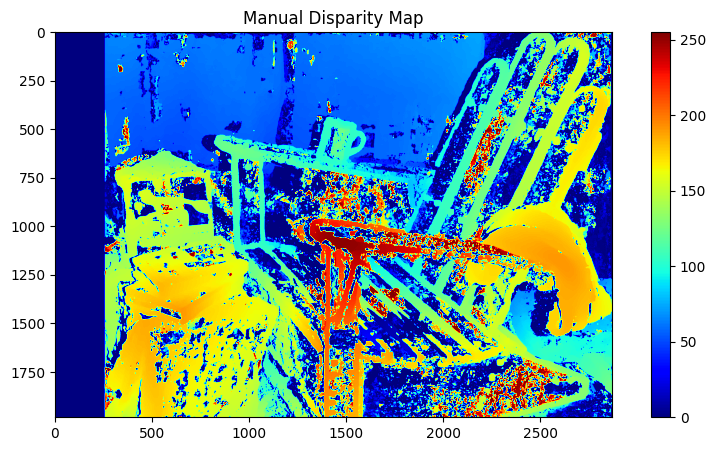

In [ ]:
disparities, xl_coords, yl_coords = calculate_disparity(keypoints_left, keypoints_right, good_matches)

stereo = cv2.StereoSGBM_create(numDisparities=256, blockSize=25)
disparity_map = stereo.compute(left_image, right_image)

plt.figure(figsize=(10, 5))
plt.imshow(disparity_map_normalized, cmap='jet')
plt.colorbar()
plt.title("Manual Disparity Map")
plt.show()

4.

In [161]:
def calculate_depth_map(disparity_map, focal_length, baseline):
    disparity_map[disparity_map == 0] = 0.1
    depth_map = (focal_length * baseline) / disparity_map
    return depth_map

/var/folders/vg/zs8tgh612f10ftq4q9bt7n200000gn/T/ipykernel_8106/3702459255.py:3: RuntimeWarning: divide by zero encountered in divide
  depth_map = (focal_length * baseline) / disparity_map


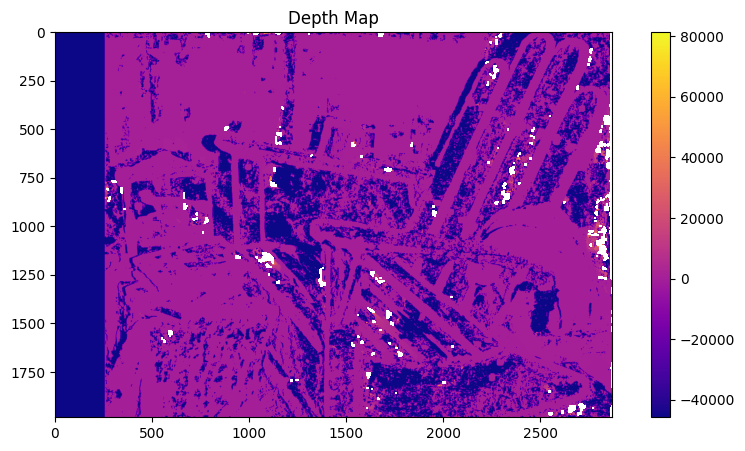

In [162]:
# Define camera parameters (as provided)
focal_length = 4152.073  # in pixels
baseline = 176.252       # in mm or the same unit

depth_map = calculate_depth_map(disparity_map, focal_length, baseline)

# Display the depth map
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.title("Depth Map")
plt.show()


### 5. What does the disparity map represent? How does it relate to depth perception? Write the Mathematical Relationship (2 Points)